In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nibabel as nib
import random

In [13]:
patient_data = pd.read_excel("./patient_data.xlsx")

In [14]:
patient_data.iloc[:6,]

,Patient ID,Stage,Cancer Type,CT File,Mask File,Liver Mask File
0,P0001,C1,HCC,ct_files/P0001_ct_C1.nii.gz,mask_files/P0001_mask_C1.nii.gz,liver_mask_files/P0001-livermask_C1.nii.gz
1,P0001,C3,HCC,ct_files/P0001_ct_C3.nii.gz,mask_files/P0001_mask_C3.nii.gz,liver_mask_files/P0001-livermask_C3.nii.gz
2,P0001,C2,HCC,ct_files/P0001_ct_C2.nii.gz,mask_files/P0001_mask_C2.nii.gz,liver_mask_files/P0001-livermask_C2.nii.gz
3,P0001,P,HCC,ct_files/P0001_ct_P.nii.gz,mask_files/P0001_mask_P.nii.gz,liver_mask_files/P0001-livermask_P.nii.gz
4,P0002,C2,HCC,ct_files/P0002_ct_C2.nii.gz,mask_files/P0002_mask_C2.nii.gz,liver_mask_files/P0002-livermask_C2.nii.gz
5,P0002,C3,HCC,ct_files/P0002_ct_C3.nii.gz,mask_files/P0002_mask_C3.nii.gz,liver_mask_files/P0002-livermask_C3.nii.gz


In [25]:
root_folder_path = "./"

# 假设我们选择第一个索引，您可以根据需要更改此索引
patient_id = 'P0059'  # 指定患者ID
stage = 'C1'  # 指定阶段
selected_row = patient_data[(patient_data['Patient ID'] == patient_id) & (patient_data['Stage'] == stage)].iloc[0]

# 读取图像和mask
liver_image = nib.load(os.path.join(root_folder_path, selected_row['CT File']))
liver_image_data = liver_image.get_fdata()
if len(liver_image_data.shape) == 4:
    liver_image_data = liver_image_data[..., 0]
elif len(liver_image_data.shape) == 5:
    liver_image_data = liver_image_data[..., 0, 0]

liver_mask = nib.load(os.path.join(root_folder_path, selected_row['Liver Mask File']))
liver_mask_data = liver_mask.get_fdata()
if len(liver_mask_data.shape) == 4:
    liver_mask_data = liver_mask_data[..., 0]
elif len(liver_mask_data.shape) == 5:
    liver_mask_data = liver_mask_data[..., 0, 0]

if pd.notna(selected_row['Mask File']):
    mask = nib.load(os.path.join(root_folder_path, selected_row['Mask File']))
    mask_data = mask.get_fdata()
    if len(mask_data.shape) == 4:
        mask_data = mask_data[..., 0]
    elif len(mask_data.shape) == 5:
        mask_data = mask_data[..., 0, 0]
else:
    mask_data = None  # 如果没有病灶mask文件


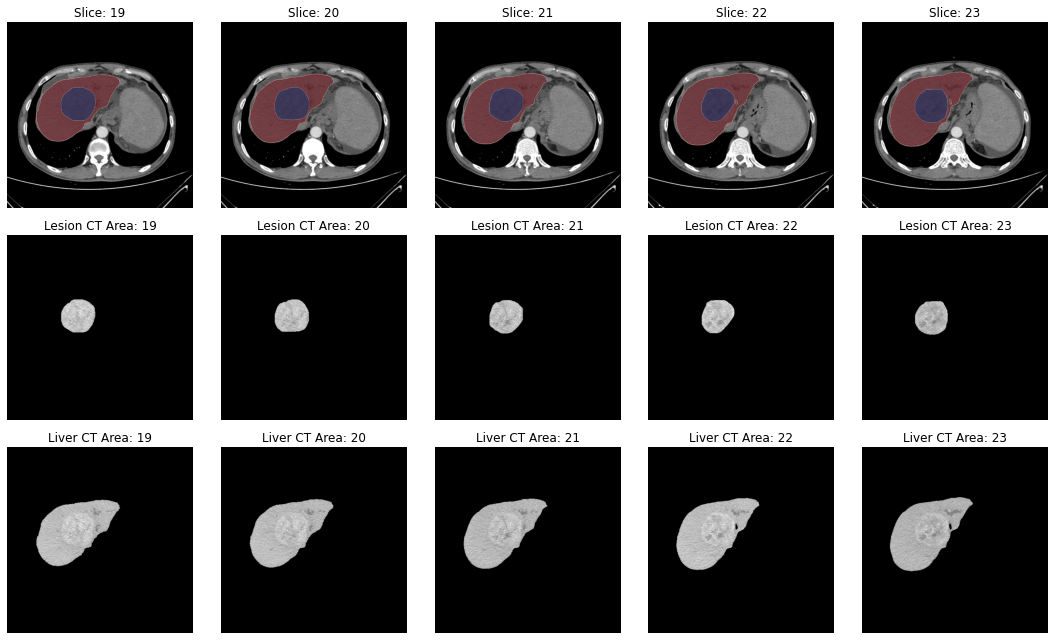

In [26]:
# 随机选择连续的5个有病灶的层
num_slices = liver_image.shape[2]
# 如果 mask_data 为 None，则不执行找病灶层的操作
if mask_data is not None:
    # 找到所有有病灶的层
    mask_slices = [i for i in range(num_slices) if np.any(mask_data[:, :, i] > 0)]
    # 从有病灶的层中随机选择一个起始点
    if len(mask_slices) > 4:
        start_slice = random.choice(range(len(mask_slices) - 4))
        # 选择连续的5个层
        random_slices = mask_slices[start_slice:start_slice + 5]
    else:
        random_slices = []
else:
    random_slices = []

# 创建子图
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
plt.rcParams['font.family'] = 'Arial'  # 设置字体为Arial

for i, slice_index in enumerate(random_slices):
    # 展示图像，顺时针旋转90°并上下镜像翻转
    axes[0, i].imshow(np.flipud(np.rot90(liver_image_data[:, :, slice_index])), cmap='gray')  
    axes[0, i].set_title(f'Slice: {slice_index}')
    axes[0, i].axis('off')
    
    # 在原图上叠加肝脏mask，使用红色透明层
    liver_mask_slice_data = np.flipud(np.rot90(liver_mask_data[:, :, slice_index]))
    liver_alpha = np.where(liver_mask_slice_data > 0, 0.5, 0)  # 只在mask区域设置透明度为0.5
    axes[0, i].imshow(liver_mask_slice_data, cmap='Reds', alpha=liver_alpha)
    
    # 如果存在病灶mask，则在同一图中叠加病灶mask，使用蓝色透明层
    if mask_data is not None:
        mask_slice_data = np.flipud(np.rot90(mask_data[:, :, slice_index]))
        mask_alpha = np.where(mask_slice_data > 0, 0.5, 0)  # 只在mask区域设置透明度为0.5
        axes[0, i].imshow(mask_slice_data, cmap='Blues', alpha=mask_alpha)
    
    # 如果存在病灶mask，则展示病灶mask对应的原CT图像区域
    if mask_data is not None:
        ct_slice_data = np.flipud(np.rot90(liver_image_data[:, :, slice_index]))
        mask_slice_data = np.flipud(np.rot90(mask_data[:, :, slice_index]))
        ct_masked_slice = np.where(mask_slice_data > 0, ct_slice_data, 0)
        axes[1, i].imshow(ct_masked_slice, cmap='gray')
        axes[1, i].set_title(f'Lesion CT Area: {slice_index}')
        axes[1, i].axis('off')

    # 展示肝脏mask对应的原CT图像区域
    liver_ct_slice_data = np.flipud(np.rot90(liver_image_data[:, :, slice_index]))
    liver_mask_slice_data = np.flipud(np.rot90(liver_mask_data[:, :, slice_index]))
    liver_ct_masked_slice = np.where(liver_mask_slice_data > 0, liver_ct_slice_data, 0)
    axes[2, i].imshow(liver_ct_masked_slice, cmap='gray')
    axes[2, i].set_title(f'Liver CT Area: {slice_index}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()